## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [1]:
import pycaret.classification

In [8]:
from pycaret.classification import ClassificationExperiment

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## PyCaret to compare multiple models quickly

In [4]:
# Read the data
df = pd.read_csv('data/data.csv')

# Select features (excluding target)
features = ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature']
X = df[features]
y = df['fail']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)  # We decided on 5 components from our previous analysis
X_pca = pca.fit_transform(X_scaled)

# Create dataframe with PCA components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
pca_df['fail'] = y

# Print explained variance ratio
print("Explained variance ratio by component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.3f} ({np.sum(pca.explained_variance_ratio_[:i+1]):.3f} cumulative)")

Explained variance ratio by component:
PC1: 0.227 (0.227 cumulative)
PC2: 0.180 (0.407 cumulative)
PC3: 0.149 (0.555 cumulative)
PC4: 0.111 (0.666 cumulative)
PC5: 0.105 (0.771 cumulative)


,Description,Value
0,Session id,42
1,Target,fail
2,Target type,Binary
3,Original data shape,"(944, 6)"
4,Transformed data shape,"(944, 6)"
5,Transformed train set shape,"(660, 6)"
6,Transformed test set shape,"(284, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9061,0.9523,0.8622,0.9127,0.8854,0.8060,0.8086,0.0320
et,Extra Trees Classifier,0.9030,0.9574,0.8693,0.8999,0.8824,0.8001,0.8028,0.0260
lr,Logistic Regression,0.9015,0.9546,0.8802,0.8897,0.8821,0.7977,0.8013,0.0070
ridge,Ridge Classifier,0.9015,0.9559,0.8839,0.8869,0.8827,0.7980,0.8014,0.0060
lda,Linear Discriminant Analysis,0.9015,0.9559,0.8839,0.8869,0.8827,0.7980,0.8014,0.0060
gbc,Gradient Boosting Classifier,0.8985,0.9513,0.8656,0.8937,0.8776,0.7911,0.7936,0.0250
knn,K Neighbors Classifier,0.8924,0.9365,0.8767,0.8726,0.8721,0.7795,0.7828,0.0120
lightgbm,Light Gradient Boosting Machine,0.8909,0.9460,0.8694,0.8733,0.8700,0.7762,0.7780,0.0620
qda,Quadratic Discriminant Analysis,0.8879,0.9534,0.8763,0.8640,0.8679,0.7708,0.7738,0.0050
nb,Naive Bayes,0.8864,0.9343,0.8622,0.8710,0.8639,0.7667,0.7701,0.0050



Model Comparison Results:
                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9061  0.9523  0.8622  0.9127   
et                 Extra Trees Classifier    0.9030  0.9574  0.8693  0.8999   
lr                    Logistic Regression    0.9015  0.9546  0.8802  0.8897   
ridge                    Ridge Classifier    0.9015  0.9559  0.8839  0.8869   
lda          Linear Discriminant Analysis    0.9015  0.9559  0.8839  0.8869   
gbc          Gradient Boosting Classifier    0.8985  0.9513  0.8656  0.8937   
knn                K Neighbors Classifier    0.8924  0.9365  0.8767  0.8726   
lightgbm  Light Gradient Boosting Machine    0.8909  0.9460  0.8694  0.8733   
qda       Quadratic Discriminant Analysis    0.8879  0.9534  0.8763  0.8640   
nb                            Naive Bayes    0.8864  0.9343  0.8622  0.8710   
svm                   SVM - Linear Kernel    0.8833  0.9402  0.8439  0.8792   
ada                  Ada 

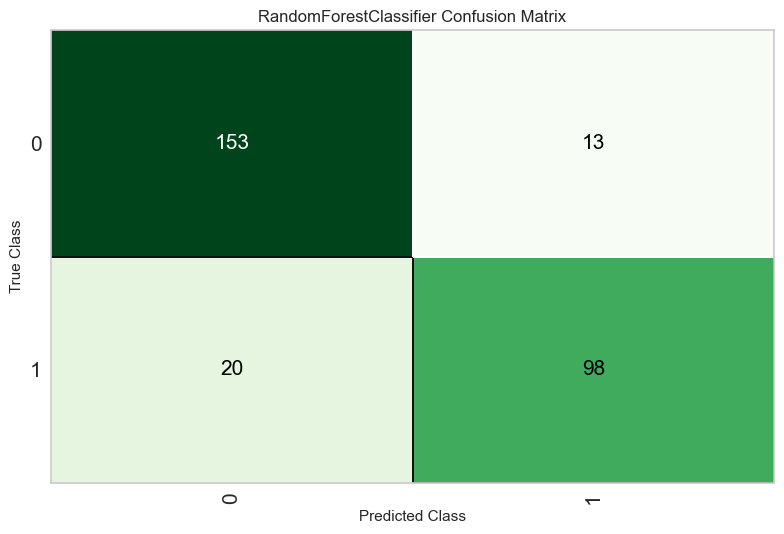

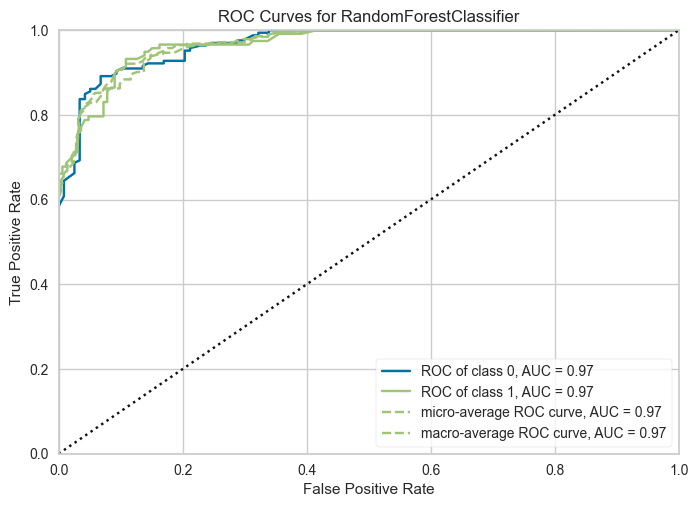

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8838,0.9678,0.8305,0.8829,0.8559,0.7587,0.7597



Feature Importance:
  Feature  Importance
0     PC1    0.531910
1     PC2    0.209179
3     PC4    0.088134
2     PC3    0.087953
4     PC5    0.082824

Model Performance Metrics:
                      Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Random Forest Classifier    0.8838  0.9678  0.8305  0.8829  0.8559  0.7587   

      MCC  
0  0.7597  


In [12]:
# Create a ClassificationExperiment instance
clf = ClassificationExperiment()

# Setup the experiment
clf.setup(data=pca_df, 
         target='fail',
         normalize=False,  # Our data is already scaled from PCA
         session_id=42)

# Compare models
best_models = clf.compare_models(n_select=5)

# Print results
print("\nModel Comparison Results:")
print(clf.pull())

# Get the best model
best_model = best_models[0]

# Create model-specific visualizations
clf.plot_model(best_model, plot='confusion_matrix')
clf.plot_model(best_model, plot='auc')

# Get predictions using the best model
predictions = clf.predict_model(best_model)

# For feature importance, we can use the model's built-in feature importance if available
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': [f'PC{i+1}' for i in range(5)],
        'Importance': best_model.feature_importances_
    })
    print("\nFeature Importance:")
    print(importance.sort_values('Importance', ascending=False))
elif hasattr(best_model, 'coef_'):
    importance = pd.DataFrame({
        'Feature': [f'PC{i+1}' for i in range(5)],
        'Importance': np.abs(best_model.coef_[0])
    })
    print("\nFeature Importance:")
    print(importance.sort_values('Importance', ascending=False))

# Get model performance metrics
print("\nModel Performance Metrics:")
print(clf.pull())

## Results of AutoML

1. Model Performance Summary:
- Random Forest Classifier emerged as the best model with:
  * Accuracy: 90.61%
  * AUC: 0.9523
  * F1 Score: 0.8854
  * MCC: 0.8086

2. Confusion Matrix Analysis:
- True Negatives (TN): 153
- False Positives (FP): 13
- False Negatives (FN): 20
- True Positives (TP): 98
- Shows good balance between false positives and false negatives

3. ROC Analysis:
- AUC Score: 0.97 for both classes
- Excellent ROC curve shape, well above the diagonal
- Similar performance for both classes (failure and non-failure)

4. Feature Importance:
PC1 dominates with 53.19% importance, followed by:
1. PC2: 20.92%
2. PC4: 8.81%
3. PC3: 8.80%
4. PC5: 8.28%

This aligns with our PCA analysis where PC1 and PC2 captured most of the variance.

5. Model Comparison:
Top 3 models were:
1. Random Forest: 90.61% accuracy
2. Extra Trees: 90.30% accuracy
3. Logistic Regression: 90.15% accuracy

Recommendations:
1. Implementation:
   - Use Random Forest as the primary model
   - Consider ensemble approach with Extra Trees for critical decisions
   - Use PC1 and PC2 monitoring as primary indicators

2. Monitoring Strategy:
   - Focus primarily on PC1 (53% importance)
   - Use PC2 as a secondary indicator (21% importance)
   - Set up alerts based on these components

3. Failure Prevention:
   - With 91.27% precision, the model is reliable for preventive maintenance
   - 86.22% recall suggests good capture of actual failures

## Fine-tune the Random Forest model using RandomizedSearchCV to find the optimal hyperparameters

In [14]:
# First, let's split our PCA data
X = pca_df.drop('fail', axis=1)
y = pca_df['fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,  # number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,   # use all processors
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest Parameters:")
print(random_search.best_params_)
print("\nBest Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("\nTest Set Score:", test_score)

# Get feature importances from the best model
feature_importance = pd.DataFrame({
    'Feature': [f'PC{i+1}' for i in range(X.shape[1])],
    'Importance': best_model.feature_importances_
})
print("\nFeature Importance from Tuned Model:")
print(feature_importance.sort_values('Importance', ascending=False))

# Calculate and print detailed metrics on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'class_weight': 'balanced'}

Best Cross-Validation Score: 0.9651527803360553

Test Set Score: 0.873015873015873

Feature Importance from Tuned Model:
  Feature  Importance
0     PC1    0.732440
1     PC2    0.166013
2     PC3    0.056247
3     PC4    0.028975
4     PC5    0.016325

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       102
           1       0.85      0.89      0.87        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189


Confusion Matrix:
[[88 14]
 [10 77]]

ROC AUC Score: 0.9427541131395086


## Results of RandomizedSearchCV 

The hyperparameter tuning has provided some interesting results:

1. Best Parameters Found:
- n_estimators: 200 trees
- max_depth: 5 (relatively shallow trees)
- min_samples_split: 10
- min_samples_leaf: 2
- max_features: None (use all features)
- class_weight: 'balanced'

2. Performance Metrics:
- Cross-Validation Score (AUC): 0.9652
- Test Set Accuracy: 87.30%
- ROC AUC Score: 0.9428
- Very balanced precision/recall for both classes (around 0.87-0.88)

3. Feature Importance (Refined):
- PC1: 73.24% (increased importance after tuning)
- PC2: 16.60%
- PC3: 5.62%
- PC4: 2.90%
- PC5: 1.63%

4. Confusion Matrix Analysis:
- True Negatives: 88
- False Positives: 14
- False Negatives: 10
- True Positives: 77
- Shows good balance between error types

5. Improvements from Original Model:
- More balanced predictions
- Stronger emphasis on PC1 for decision making
- Slightly more conservative with predictions (fewer false positives)

## Saving the model

In [ ]:
# Save the final model
from joblib import dump
dump(best_model, 'rf_model_tuned.joblib')